# Model Monitoring KPI Example
This notebook demonstrates how to use the `model_monitoring` module to define and analyze Key Performance Indicators (KPIs) across different data segments.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

from model_monitoring import (
    AnalysisDataBuilder,
    SegmentCategorical,
    SegmentCustom,
    calculate_statistics,
)
from model_monitoring.plotting import plot_segment_statistics, set_plot_theme

## 1. Generate Synthetic Data

First, we'll create a synthetic dataset. This dataset mimics a typical insurance scenario with multiple coverages, predictions (risk premiums), and observed outcomes (targets/claims). The data is saved to a parquet file.

In [2]:
# --- Create a Synthetic Dataset ---
np.random.seed(42)
n_samples = 10000

# Create some numerical features
features = pd.DataFrame(
    {
        "age": np.random.randint(18, 70, n_samples),
        "income": np.random.gamma(2, 40000, n_samples),
        "credit_score": np.random.randint(300, 850, n_samples),
        "market_premium": np.random.uniform(0.1, 0.5, n_samples),
    }
)

# Create a categorical feature
features["region"] = np.random.choice(
    ["North", "South", "East", "West"], n_samples, p=[0.3, 0.2, 0.25, 0.25]
)

# --- Generate data for N=3 coverages in a wide format ---
N_coverages = 3
df = features.copy()

for i in range(N_coverages):
    cov_suffix = f"_{chr(65 + i)}"  # e.g., _A, _B, _C

    # --- Generate True Risk (rate for Poisson) ---
    true_risk_formula = (
        -4.0
        + (i * 0.1)
        + df["age"] / (20 + i * 2)
        - df["credit_score"] / (500 + i * 20)
        + df["income"] / 100000
    )
    true_risk_index = np.exp(true_risk_formula)

    # --- Generate a Slightly Incorrect Prediction ---
    prediction_formula = (
        -3.9
        + (i * 0.1)
        + df["age"] / (22 + i * 2)
        - df["credit_score"] / (550 + i * 20)
        + df["income"] / 110000
    )
    df[f"prediction{cov_suffix}"] = np.exp(prediction_formula)

    # --- Generate Target (claims) from the true risk ---
    df[f"target{cov_suffix}"] = np.random.poisson(true_risk_index)

# Add a single weight column
df["weight"] = 1.0

# Save to parquet
output_path = "../../data/segmentation_data.parquet"
df.to_parquet(output_path)

print(f"Synthetic data generated and saved to {output_path}")
df.head()

Synthetic data generated and saved to ../../data/segmentation_data.parquet


,age,income,credit_score,market_premium,region,prediction_A,target_A,prediction_B,target_B,prediction_C,target_C,weight
0,56,31626.419807,693,0.295256,West,0.097585,0,0.091178,0,0.087754,0,1.0
1,69,94350.676790,565,0.230289,East,0.393303,0,0.346978,1,0.317891,0,1.0
2,46,34226.773664,803,0.112133,South,0.051926,0,0.050744,0,0.050761,0,1.0
3,32,189107.488476,433,0.410269,North,0.220123,0,0.221539,0,0.226736,1,1.0
4,60,32588.089714,325,0.305161,South,0.230528,0,0.207231,0,0.192646,0,1.0


## 2. Configure the Analysis

Now, we set up the analysis by defining the coverages, segmentation strategies, and data treatments.

### Prediction & Target Mapping
We create a dictionary to map each coverage to its corresponding prediction, target, and weight columns.

In [3]:
pred_dict = {
    "B": {"sel_col": "weight", "pred_col": "prediction_B", "target_col": "target_B"},
    }

### Segmentation Strategies
We define how to segment the data. We can create segments from categorical features or by binning numerical features.

In [4]:
segments = [
    # Segment for Age with custom bins
    SegmentCustom(
        seg_col="age",
        seg_name="age_group",
        bins=[18, 30, 45, 60, 75],
        bin_labels=["18-29", "30-44", "45-59", "60+"],
    ),
    # Segment for Income with 5 equal-width bins
    SegmentCustom(seg_col="income", seg_name="income_level", bins=5),
    # Segment for Region (each category is a segment)
    SegmentCategorical(seg_col="region", seg_name="region_segment"),
]
print(f"{len(segments)} segments defined.")

3 segments defined.


### Initialize Analysis and Apply Treatments
We initialize the `AnalysisDataBuilder` object, which orchestrates the data loading, treatment, and segmentation. Treatments are applied to the data, such as iso resources scaling of predictions or aggregating totals.

In [7]:
# Initialize AnalysisDataBuilder with the data path
lr_analysis = AnalysisDataBuilder(data=output_path, extra_cols=["market_premium", "weight", "prediction_B", "target_B"])


# Add segments
for s in segments:
    lr_analysis.add_segment(s)

# Load data and apply all defined steps
lr_analysis.load_data()
lr_analysis.apply_treatments()
lr_analysis.apply_segments()

print("Analysis configured. Treated and segmented data is ready.")
lr_analysis.db.head()

Analysis configured. Treated and segmented data is ready.


,market_premium,weight,prediction_B,target_B,age,income,region,age_group,income_level,region_segment
0,0.295256,1.0,0.091178,0,56,31626.419807,West,45-59,"[220.929, 109734.013)",West
1,0.230289,1.0,0.346978,1,69,94350.676790,East,60+,"[220.929, 109734.013)",East
2,0.112133,1.0,0.050744,0,46,34226.773664,South,45-59,"[220.929, 109734.013)",South
3,0.410269,1.0,0.221539,0,32,189107.488476,North,30-44,"[109734.013, 219247.098)",North
4,0.305161,1.0,0.207231,0,60,32588.089714,South,60+,"[220.929, 109734.013)",South


## 3. Calculate Statistics (KPIs)

With the data prepared, we can now define and calculate our KPIs. We can compute simple statistics for our analysis.

In [10]:
# --- Define Statistics to Calculate ---
func_dict = {
    "aggregations": {
        "prediction_B": ("weighted_mean", ["prediction_B", "weight"]),
        "target_B": ("observed_charge", ["target_B", "weight"]),
        "gini": ("gini", ["target_B", "prediction_B", "weight"]),
        "exposure(k)": (lambda df, e: df[e].sum() / 1000, ["weight"]),
    },
    "post_aggregations": {
        "S/PP": ("division", ["target_B", "prediction_B"]),
    },
}

# Calculate statistics
dict_stats, agg_stats = calculate_statistics(lr_analysis, func_dict, bootstrap=False)

print("--- Overall Statistics ---")
agg_stats

--- Overall Statistics ---


prediction_B     0.155593
target_B         0.167000
gini             0.531941
exposure(k)     10.000000
S/PP             1.073315
dtype: float64

Here are the statistics for the `age_group` segment:

In [11]:
dict_stats["age_group"]

,prediction_B,target_B,gini,exposure(k),S/PP,segment
age_group,,,,,,
18-29,0.055119,0.045962,0.464061,2.241,0.833863,age_group
30-44,0.098696,0.105831,0.437037,2.967,1.072292,age_group
45-59,0.185095,0.201736,0.400921,2.880,1.089906,age_group
60+,0.317208,0.351464,0.404079,1.912,1.107994,age_group


## 4. Visualize Segmented KPIs

Finally, we visualize the calculated KPIs. The plotting module is flexible and allows for creating multi-panel reports with different chart types.

### Set Plotting Theme
We can set a consistent theme for all our plots.

In [12]:
set_plot_theme(
    annotation_fontsize=14, style="ggplot", target_color="#1E1D25", h_line_style=":"
)

### Generate Visualization Report
We define a list of panels to create a comprehensive report. Each panel can be customized (plot type, colors, etc.). Here we show a report with line plots, confidence interval bands, and a bar chart for exposure.

--- Report for age_group ---


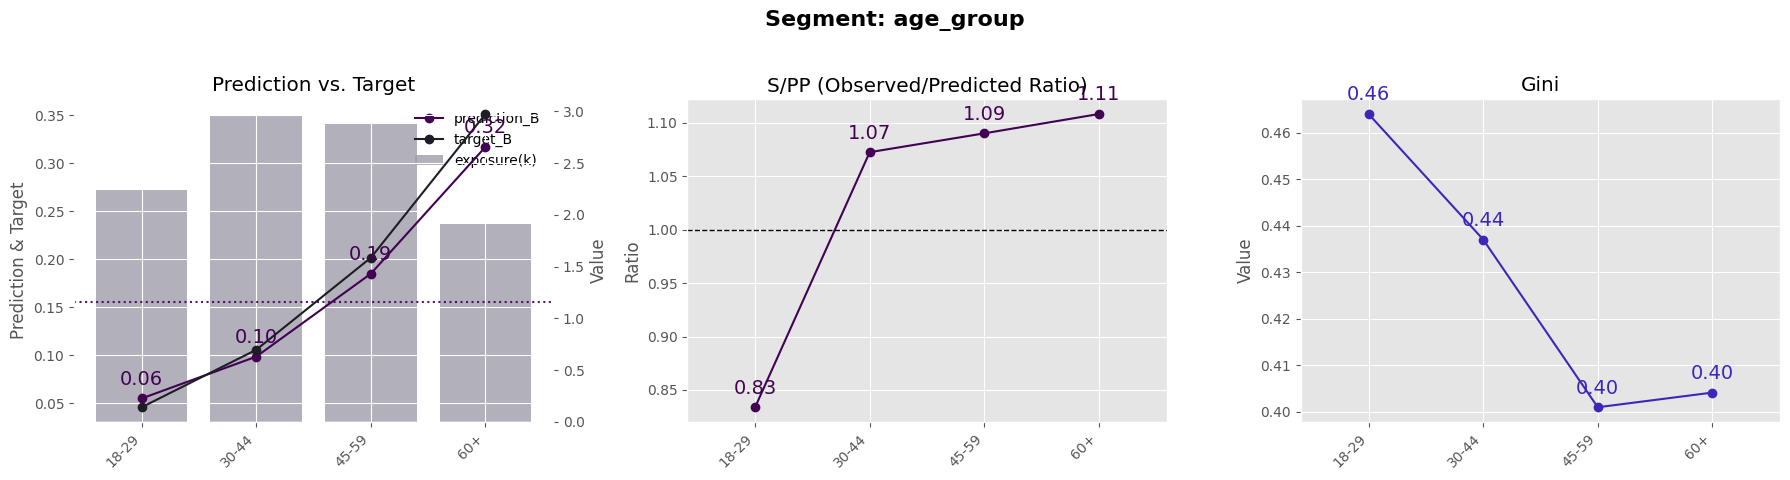

--- Report for income_level ---


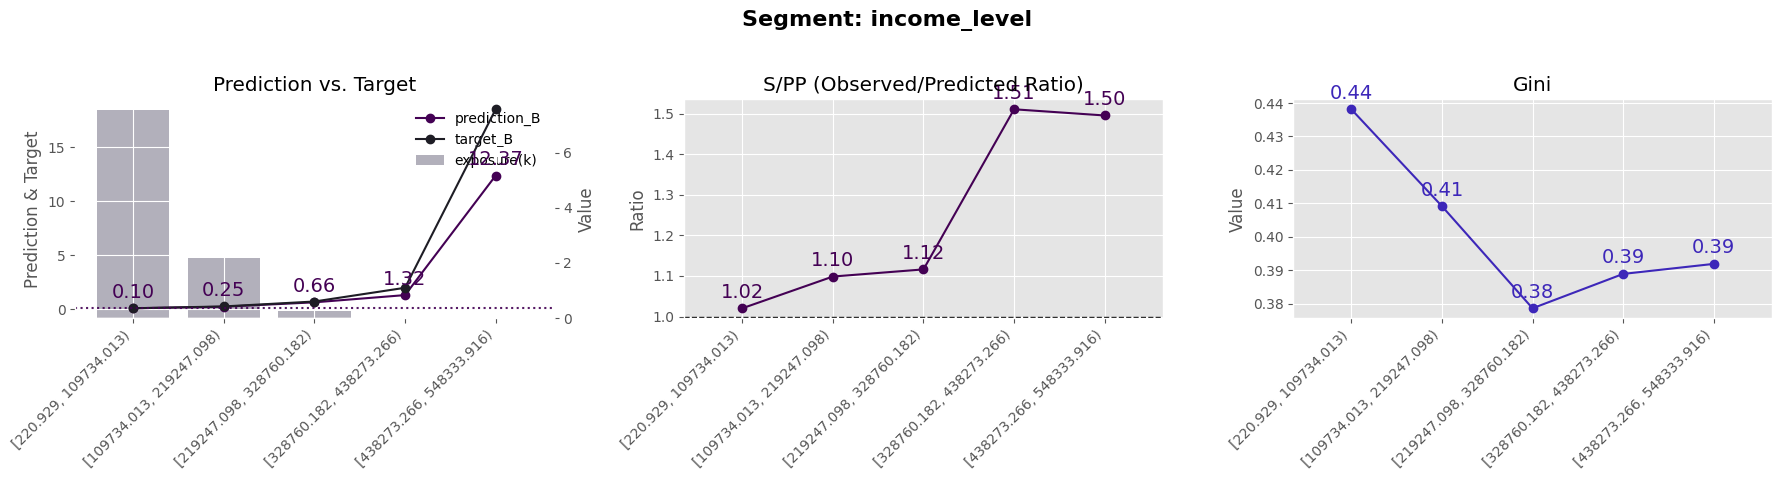

--- Report for region_segment ---


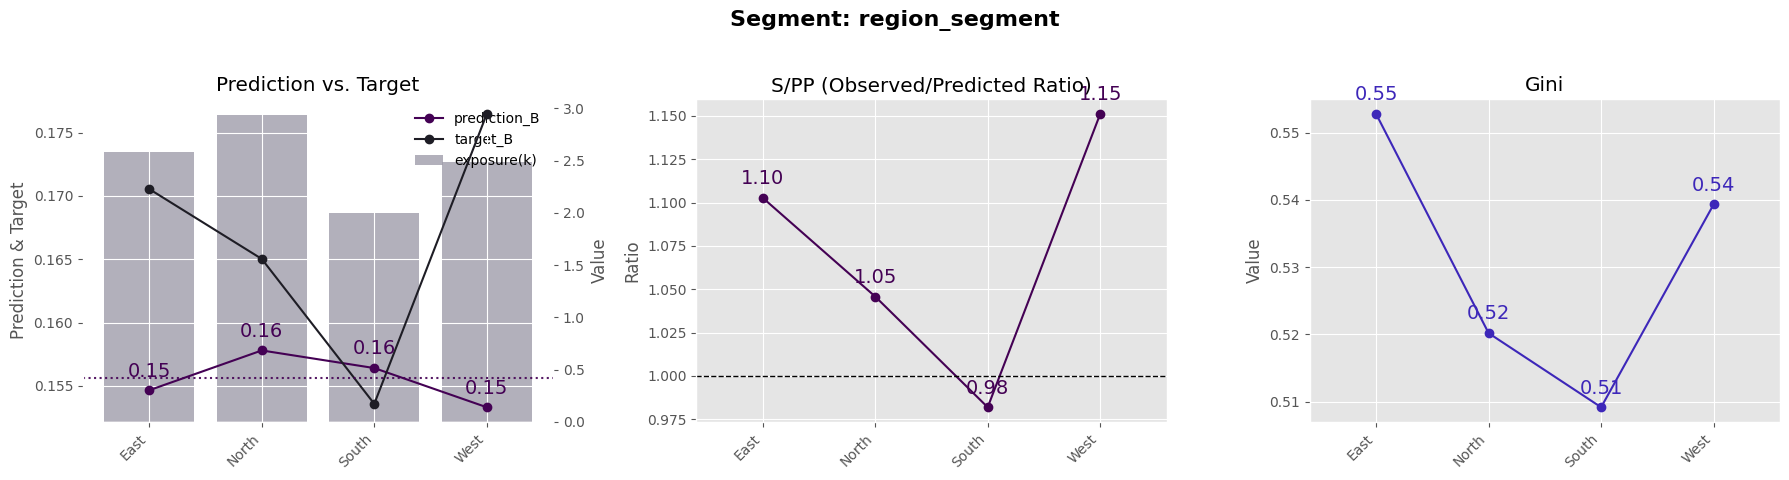

In [15]:
# Define the panels for the plot
report_panels = [
    {
        "title": "Prediction vs. Target",
        "type": "pred_vs_target",
        "pred_col": ["prediction_B" ],
        "target_col": "target_B",
        "plot_type": "line",
        "show_mean_line": "all",
    },
    {
        "title": "S/PP (Observed/Predicted Ratio)",
        "type": "spp",
        "spp_col": ["S/PP"],
        "plot_type": "line",
        "show_mean_line": False,
    },
    {
        "title": "Prediction vs. Target",  # As the title is reused, this panel will be a twin plot on the same axis
        "type": "exposure",
        "metric_col": "exposure(k)",
        "plot_type": "bar",
        "colors": ["#9F9DAA"],
    },
    {
        "title": "Gini",  # As the title is reused, this panel will be a twin plot on the same axis
        "type": "metric",
        "metric_col": "gini",
        "plot_type": "line",
        "colors": ["#3D27B9"],
    },
]


# Iterate over each segment's statistics and generate a plot
for segment_name, stats_df in dict_stats.items():
    print(f"--- Report for {segment_name} ---")
    plot_segment_statistics(stats_df, panel_configs=report_panels, agg_stats=agg_stats)